In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.4.1 cuda: True


In [2]:
## Load dataset
data_path = "../../../rings_fixed_radius"
Data = torch.from_numpy(np.load(data_path + '/obs.npy')).float()
FIXED_RADIUS = 1.5

NUM_DATASETS, N, D = Data.shape
K = 3 ## number of clusters
SAMPLE_SIZE = 10
NUM_HIDDEN_GLOBAL = 8
NUM_HIDDEN_LOCAL = 64
NUM_STATS = 16

MCMC_SIZE = 10
BATCH_SIZE = 20
NUM_EPOCHS = 300
LEARNING_RATE = 1e-4
CUDA = torch.cuda.is_available()
PATH = 'baseline-mlp-%dsamples' % (SAMPLE_SIZE)
DEVICE = torch.device('cuda:0')

obs_rad = torch.ones(1) * FIXED_RADIUS
noise_sigma = torch.ones(1) * 0.05
if CUDA:
    obs_rad = obs_rad.cuda().to(DEVICE)
    noise_sigma = noise_sigma.cuda().to(DEVICE)
Train_Params = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE, CUDA, DEVICE, PATH)
Model_Params = (obs_rad, noise_sigma, N, K, D)

In [3]:
from local_enc import *
from global_oneshot import *
## if reparameterize continuous variables
Reparameterized = False
# initialization
enc_z = Enc_z(K, D, NUM_HIDDEN_LOCAL, CUDA, DEVICE)
if CUDA:
    enc_z.cuda().to(DEVICE)
oneshot_eta = Oneshot_mu(K, D, NUM_HIDDEN_GLOBAL, NUM_STATS, CUDA, DEVICE, Reparameterized)
if CUDA:
    oneshot_eta.cuda().to(DEVICE)
optimizer =  torch.optim.Adam(list(oneshot_eta.parameters())+list(enc_z.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))
models = (oneshot_eta, enc_z)

In [4]:
from os_ep import *
train(models, EP, optimizer, Data, Model_Params, Train_Params)

epoch: 0\300 (12s),  eubo: -592004.648,  elbo: -732524.416,  ess: 1.000
epoch: 1\300 (11s),  eubo: -515413.544,  elbo: -605122.896,  ess: 1.000
epoch: 2\300 (12s),  eubo: -448580.894,  elbo: -535850.884,  ess: 1.000
epoch: 3\300 (12s),  eubo: -373136.619,  elbo: -496055.128,  ess: 1.000
epoch: 4\300 (12s),  eubo: -304603.618,  elbo: -452203.975,  ess: 1.000
epoch: 5\300 (12s),  eubo: -270437.748,  elbo: -430380.566,  ess: 1.000
epoch: 6\300 (12s),  eubo: -247786.270,  elbo: -409935.050,  ess: 1.001
epoch: 7\300 (12s),  eubo: -232546.945,  elbo: -401157.890,  ess: 1.000
epoch: 8\300 (12s),  eubo: -230784.870,  elbo: -400911.463,  ess: 1.000
epoch: 9\300 (12s),  eubo: -205905.830,  elbo: -377902.499,  ess: 1.000
epoch: 10\300 (12s),  eubo: -209615.968,  elbo: -380042.328,  ess: 1.000
epoch: 11\300 (11s),  eubo: -206328.369,  elbo: -382913.915,  ess: 1.000
epoch: 12\300 (11s),  eubo: -193553.465,  elbo: -370041.792,  ess: 1.000
epoch: 13\300 (12s),  eubo: -184156.000,  elbo: -367722.592, 

In [5]:
torch.save(enc_z.state_dict(), "../weights/enc-z-%s" % PATH)
torch.save(oneshot_eta.state_dict(), "../weights/oneshot-eta-%s" % PATH)

In [6]:
BATCH_SIZE_TEST = 50
Train_Params_Test = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE_TEST, CUDA, DEVICE, PATH)
obs, metric_step, reused = test(models, EP, Data, Model_Params, Train_Params_Test)
(q_mu, _, q_z, _) = reused

IndexError: too many indices for tensor of dimension 1

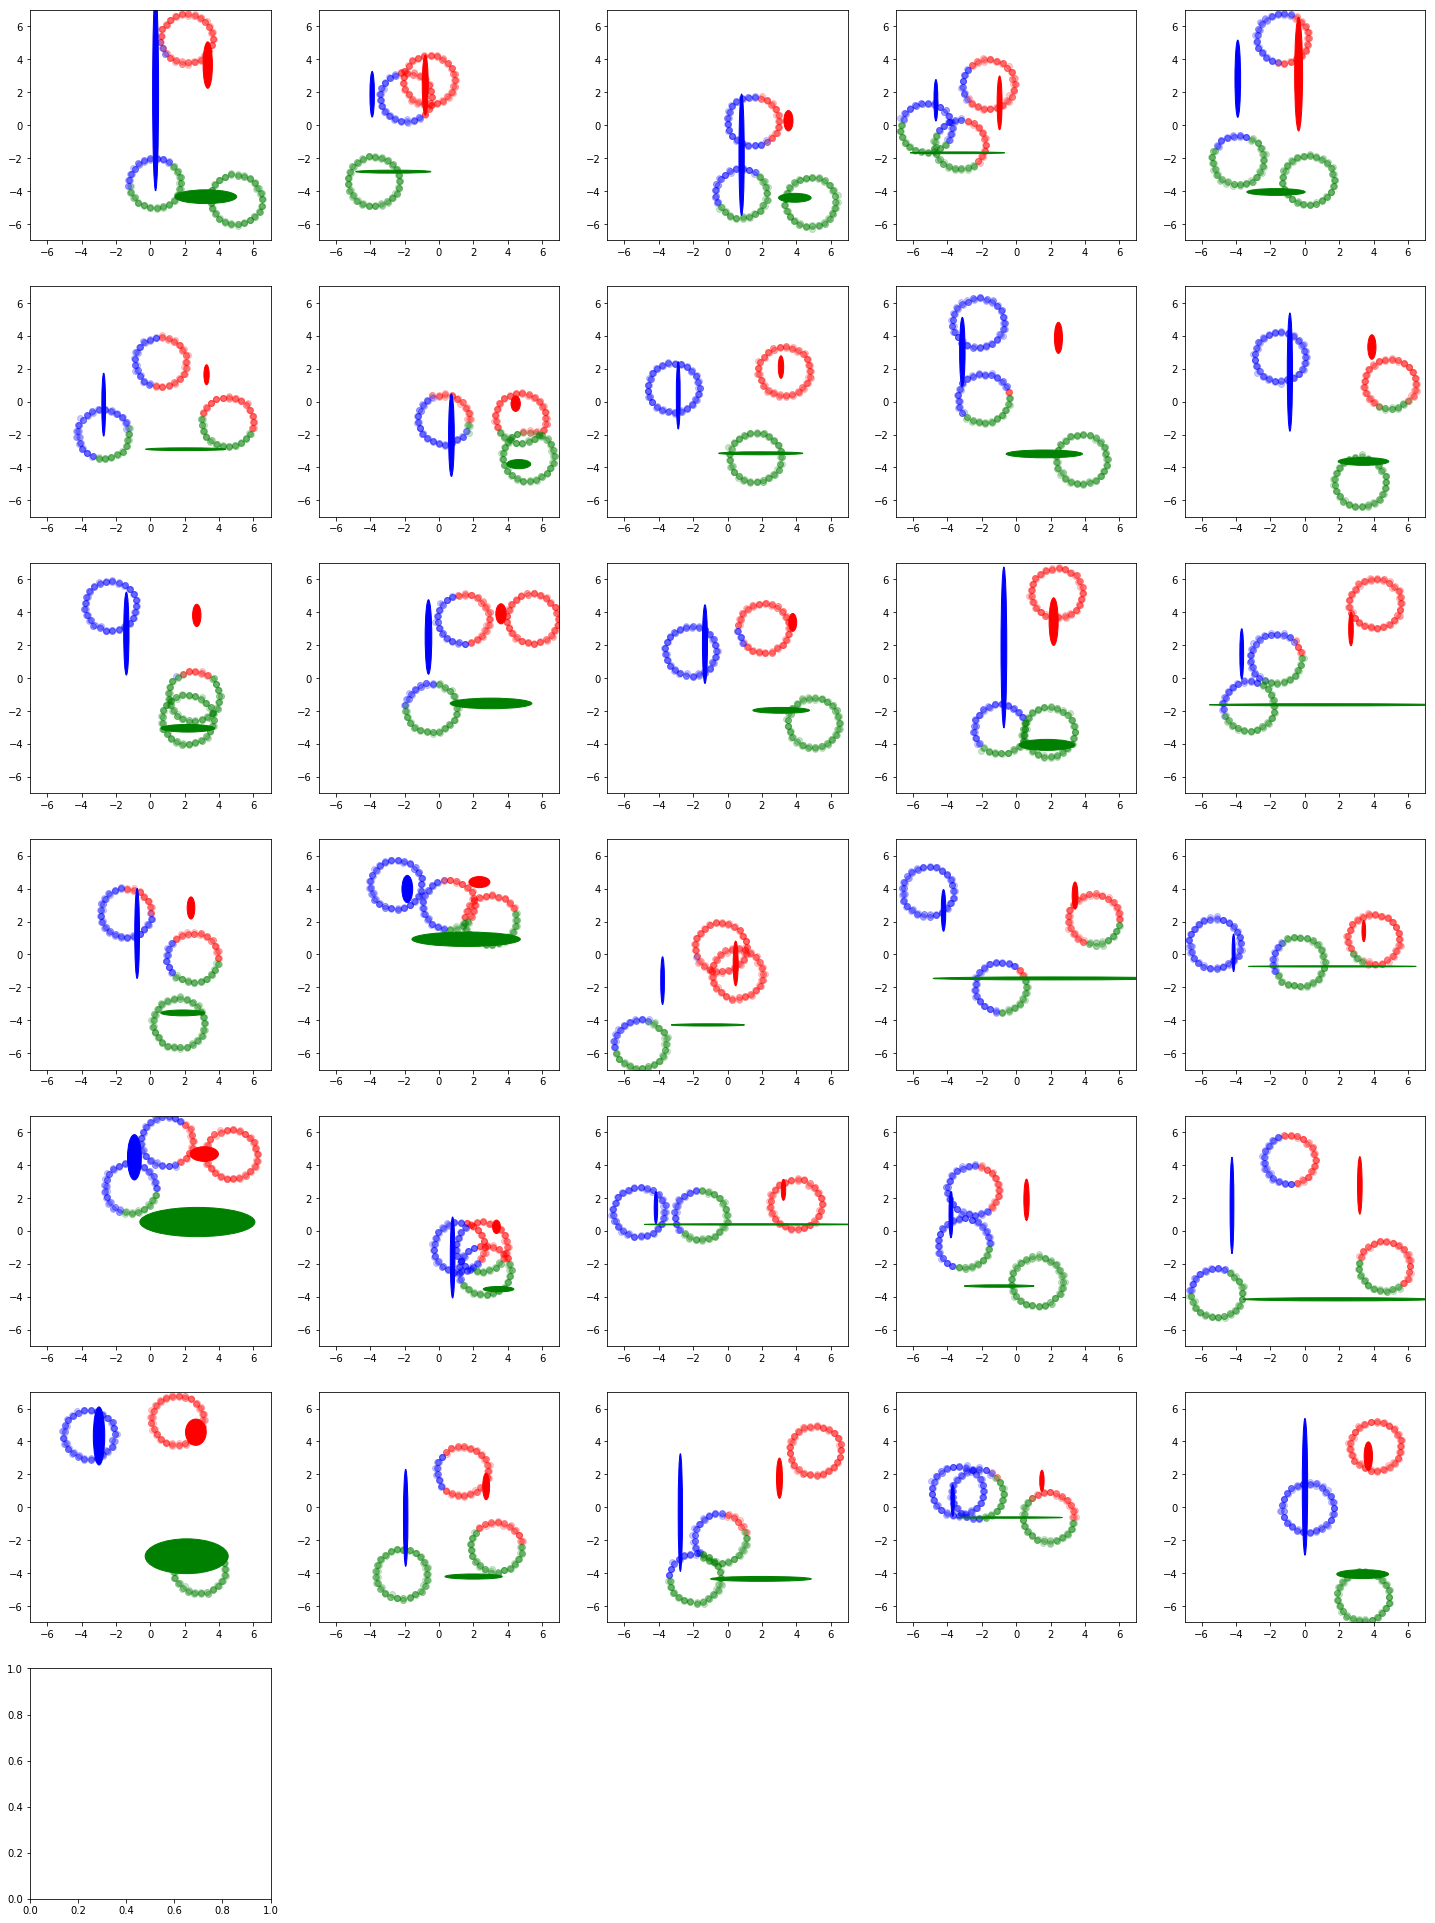

In [7]:
%time plot_samples(obs, q_mu, q_z, K, PATH)

In [8]:
incremental_gap = symkls_test.cpu().data.numpy()[1:]
M = incremental_gap.shape[0]
overall_gap = np.zeros(M)
for m in range(M):
    overall_gap[m] = incremental_gap[:m+1].sum()

NameError: name 'symkls_test' is not defined

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.yscale("log")
ax.plot(incremental_gap, label="incremental gap")
ax.plot(overall_gap, label='overall gap')
ax.legend(fontsize=14)
ax.set_xlabel('Steps')